# Project: Data Analysis

In this project, I want to find the most frequent topics from unstructured complaint texts using Natural Language Processing (NLP) techniques. I selected the dataset “Air France Reviews” from Kaggle, which includes unstructured customer feedback about airline services. These reviews often express detailed complaints and opinions about flight delays, food, staff, and comfort, making them ideal for identifying key topics through NLP.

## Text Preprocessing
* Removing punctuation
* Lowercasing
* Eliminating Stopwords
* Lemmatization

## Vectorization Techniques
* TF-IDF via Sklearn
* Sentence BERT

## Topic Extraction
* LDA
* BERTopic

## Notebook Imports

In [1]:
!pip install sentence-transformers
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.9.90:
      Successfully uninstalled nvidia-curand-cu12-10.3.9.90
  Attemptin

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
from pprint import pprint

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Transformers
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

# Gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.models.ldamodel import LdaModel, CoherenceModel
from gensim.corpora import Dictionary

# Pytorch 
import torch
import torch.nn as nn

# Warnings 
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

2025-05-20 10:33:53.349886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747737233.673831      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747737233.804148      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/google/cloud/automl_v1/proto/annotation_payload_pb2.py:277: DeprecationWarning: invalid escape sequence '\_'
  __doc__="""Contains annotation information that is relevant to
/usr/local/lib/python3.11/dist-packages/google/cloud/automl_v1/proto/classification_pb2.py:679: DeprecationWarning: invalid escape sequence '\_'
  __doc__="""Metrics for a single confidence threshold.
/usr/local/lib/python3

## Data Loading

In [3]:
dataset = pd.read_csv("/kaggle/input/air-france-reviews-dataset/airfrance_tripadvisor_reviews.csv")
dataset.head()

,rating,title,text,publishedDate
0,1,WORST AIRLINE,I travel a lot - and I travel often. Last week...,2024-11-13
1,1,Terrible experience with Airfrance,"This review is regarding flight AF185, we book...",2024-11-13
2,1,Extremely Disappointing Experience with Air Fr...,I recently flew with Air France on flight #185...,2024-11-12
3,1,Horrible,Wow!!! What a horrible experience!! I've alway...,2024-11-11
4,1,The Worst Flight Experience I’ve Ever Had,I spent a fantastic 10-day vacation in Hong Ko...,2024-11-11


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rating         2560 non-null   int64 
 1   title          2560 non-null   object
 2   text           2560 non-null   object
 3   publishedDate  2560 non-null   object
dtypes: int64(1), object(3)
memory usage: 80.1+ KB


In [5]:
dataset.duplicated().sum()

0

In [6]:
dataset.shape

(2560, 4)

## Data Visualization

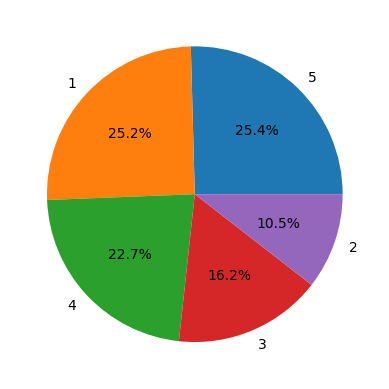

In [7]:
rating = dataset['rating'].value_counts()
labels = rating.keys()
plt.pie(rating, labels=labels, autopct='%1.1f%%')
plt.show()

## Data Cleaning

In [8]:
def preprocess_text(text: str, stopwords=set(stopwords.words('english')), wnl=WordNetLemmatizer()):
    
    """
    Preprocesses the input text by tokenizing, removing stopwords and punctuation, and lemmatizing the words.
    
    Args:
        text (str): The input text to be preprocessed.
        stopwords (set, optional): A set of stopwords to be removed from the text. Defaults to nltk's English stopwords.
        wnl (WordNetLemmatizer, optional): An instance of WordNetLemmatizer for lemmatizing words. Defaults to an instance of WordNetLemmatizer.
        
    Returns:
        list or str: The preprocessed text. 
    """
    
    # Tokenising
    words = word_tokenize(text.lower())
    
    # Removing Stopwords & Punctuation
    filtered_text = [word for word in words if word not in stopwords and word.isalpha()]
    
    # Lemmatization
    preprocessed_text = [wnl.lemmatize(word) for word in filtered_text]
    
    return preprocessed_text

In [9]:
dataset['text'] = dataset['text'].apply(preprocess_text)
dataset.head()

,rating,title,text,publishedDate
0,1,WORST AIRLINE,"[travel, lot, travel, often, last, week, flew,...",2024-11-13
1,1,Terrible experience with Airfrance,"[review, regarding, flight, booked, economy, f...",2024-11-13
2,1,Extremely Disappointing Experience with Air Fr...,"[recently, flew, air, france, flight, hong, ko...",2024-11-12
3,1,Horrible,"[wow, horrible, experience, always, flown, por...",2024-11-11
4,1,The Worst Flight Experience I’ve Ever Had,"[spent, fantastic, vacation, hong, kong, famil...",2024-11-11


In [10]:
dataset.drop(['title', 'publishedDate'], axis=1, inplace=True)
dataset.head()

,rating,text
0,1,"[travel, lot, travel, often, last, week, flew,..."
1,1,"[review, regarding, flight, booked, economy, f..."
2,1,"[recently, flew, air, france, flight, hong, ko..."
3,1,"[wow, horrible, experience, always, flown, por..."
4,1,"[spent, fantastic, vacation, hong, kong, famil..."


In [11]:
len(dataset.text.max())

115

## Text Vectorization

###  TF-IDF via Sklearn → based on word **frequency**

In [12]:
dataset['cleaned_text'] = dataset['text'].apply(" ".join)
documents = [item for item in dataset['cleaned_text']]

In [13]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=10, ngram_range=(1,2))
vectors = vectorizer.fit_transform(documents)
vectors.shape

(2560, 2444)

In [14]:
feature_names = vectorizer.get_feature_names_out()

In [15]:
tfidf_df = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.head()

,ability,able,able get,aboard,absolute,absolutely,accept,acceptable,access,accommodating,...,wrote,year,year ago,year old,yes,yet,york,young,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.045582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


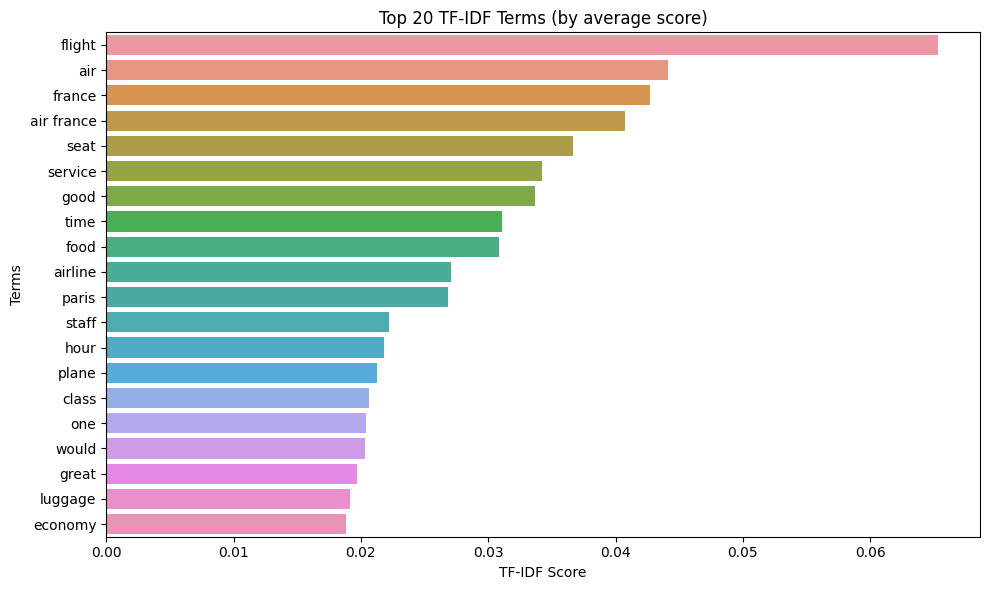

In [16]:
tfidf_means = np.asarray(vectors.mean(axis=0)).flatten()
top_indices = tfidf_means.argsort()[::-1][:20]
top_terms = [feature_names[i] for i in top_indices]
top_scores = tfidf_means[top_indices]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_scores, y=top_terms)
plt.title("Top 20 TF-IDF Terms (by average score)")
plt.xlabel("TF-IDF Score")
plt.ylabel("Terms")
plt.tight_layout()
plt.show()

###  BERT → based on **meaning**

In [17]:
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = sentence_model.encode(documents)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/80 [00:00<?, ?it/s]

In [18]:
emdeddings_df = pd.DataFrame(embeddings)
emdeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.069206,-0.066198,0.026900,0.030805,0.066946,-0.013750,0.085353,-0.040484,-0.002221,0.009129,...,-0.000656,-0.008219,-0.091338,0.054823,0.103289,-0.028181,0.053024,0.022535,-0.027946,-0.032500
1,0.083266,0.016886,-0.012539,0.069055,0.061506,0.036894,0.104493,-0.014165,-0.010731,0.004222,...,0.027027,0.027678,-0.033869,-0.003622,0.021766,0.037178,0.058442,-0.014316,-0.113472,0.061123
2,0.050852,-0.009472,0.055006,0.007082,0.002140,0.045306,0.052290,-0.043622,0.015922,-0.007152,...,-0.003959,0.017301,-0.019241,0.015925,0.024874,0.058386,0.096711,-0.005602,-0.091108,0.059969
3,0.054888,-0.021453,0.035356,-0.009695,0.016970,-0.020026,0.118477,-0.038332,0.001904,-0.046394,...,0.016345,0.030377,-0.035024,0.008600,0.023281,0.001608,0.066032,0.063588,-0.068881,-0.036297
4,0.017907,-0.040788,0.073796,0.026372,0.010069,0.070131,0.059134,-0.046027,-0.011538,0.015346,...,0.032383,0.049528,0.004980,0.062112,0.026843,0.039823,0.048548,0.042019,-0.090151,0.040546


In [19]:
emdeddings_df.shape

(2560, 384)

## Topic Modelling

### Latent Dirichlet Allocation (LDA)

In [20]:
# Create a Dictionary
id2word = Dictionary(dataset['text'])
docs = dataset['text']
corpus = [id2word.doc2bow(doc) for doc in docs]

In [21]:
# 10 words from corpus
corpus_words = [[(id2word[i], freq) for i, freq in cp] for cp in corpus[:10]]
corpus_words[0][:10]

[('additional', 1),
 ('advice', 1),
 ('air', 8),
 ('airline', 2),
 ('airport', 6),
 ('algiers', 1),
 ('also', 2),
 ('always', 3),
 ('around', 1),
 ('attendant', 1)]

In [22]:
num_topics = 15
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, 
                     random_state=42, update_every=1, chunksize=250, 
                     passes=10, alpha='auto', per_word_topics=True)

lda_topics = lda_model.print_topics(num_words=8)

In [23]:
# Coherence Score
coherence_model = CoherenceModel(model=lda_model, texts=docs,
                                 dictionary=id2word, coherence='c_v')
coherence_model.get_coherence()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


0.5308939422993162

In [24]:
pprint(lda_topics)

[(0,
  '0.051*"seat" + 0.031*"flight" + 0.031*"food" + 0.025*"good" + '
  '0.021*"economy" + 0.021*"class" + 0.019*"service" + 0.017*"business"'),
 (1,
  '0.052*"de" + 0.043*"charles" + 0.036*"terminal" + 0.035*"gate" + '
  '0.034*"gaulle" + 0.030*"airport" + 0.026*"boarding" + 0.025*"cdg"'),
 (2,
  '0.039*"manchester" + 0.039*"efficient" + 0.039*"polite" + 0.032*"amenity" + '
  '0.028*"usual" + 0.026*"plug" + 0.019*"interior" + 0.019*"haul"'),
 (3,
  '0.047*"example" + 0.038*"mostly" + 0.021*"overly" + 0.009*"wearing" + '
  '0.006*"extended" + 0.003*"skipped" + 0.003*"handing" + 0.002*"accompany"'),
 (4,
  '0.056*"recline" + 0.038*"plenty" + 0.036*"prefer" + 0.031*"difference" + '
  '0.028*"equipment" + 0.026*"pillow" + 0.025*"modern" + 0.021*"website"'),
 (5,
  '0.048*"cheese" + 0.047*"glass" + 0.032*"inedible" + 0.028*"dish" + '
  '0.021*"roll" + 0.016*"starter" + 0.013*"dessert" + 0.012*"plate"'),
 (6,
  '0.050*"la" + 0.049*"major" + 0.043*"madrid" + 0.025*"location" + '
  '0.022*"

In [25]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.328966  0.064914       1        1  55.505650
0     -0.373337 -0.145685       2        1  24.797130
12    -0.110317  0.291455       3        1   5.470804
8     -0.286193 -0.187775       4        1   4.730042
11    -0.026788  0.217115       5        1   3.279569
1     -0.032448  0.109815       6        1   2.699545
4      0.113563 -0.023237       7        1   0.940539
2      0.123323 -0.047838       8        1   0.749422
6      0.129463 -0.042890       9        1   0.541231
5      0.130825 -0.041988      10        1   0.300035
7      0.133416 -0.042249      11        1   0.294566
9      0.132640 -0.038569      12        1   0.264054
10     0.134389 -0.043791      13        1   0.215724
13     0.130380 -0.035083      14        1   0.118048
3      0.130051 -0.034195      15        1   0.093641, topic_info=             Term         Freq        Total Category  logprob  loglift
277          good  1272.000000  1272.000000  Default  30.0000  30.0000
152          seat  1811.000000  1811.000000  Default  29.0000  29.0000
237          time  1510.000000  1510.000000  Default  28.0000  28.0000
93          staff   822.000000   822.000000  Default  27.0000  27.0000
62        luggage   830.000000   830.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
7324  superfluous     0.012827     0.731562  Topic15  -9.2468   2.9299
4396   particular     0.012858     0.733770  Topic15  -9.2444   2.9292
4579   unfriendly     0.012899     0.737014  Topic15  -9.2412   2.9280
4002        didnt     0.012856     0.735661  Topic15  -9.2445   2.9265
3475      stretch     0.012851     0.734598  Topic15  -9.2449   2.9276

[656 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2741      5  0.977174  accommodating
829      10  0.467627    accompanied
2080      3  0.977806        account
322       1  0.329068             af
322       2  0.596742             af
...     ...       ...            ...
2252      9  0.957129        writing
114       1  0.950666           year
114       2  0.046908           year
479       4  0.985204           york
2223     11  0.783289         zurich

[734 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 1, 13, 9, 12, 2, 5, 3, 7, 6, 8, 10, 11, 14, 4])

### BertTopic

In [26]:
# Sentence Model
bertopic_model = BERTopic(embedding_model=sentence_model, vectorizer_model=vectorizer)
topics, probs = bertopic_model.fit_transform(documents, embeddings)

In [27]:
freq_bert = bertopic_model.get_topic_info()
freq_bert

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1489,-1_france_air france_paris_cdg,"[france, air france, paris, cdg, delta, minute...",[air france ruined vacation gave wife worst ne...
1,0,168,0_lost_luggage_bag_day,"[lost, luggage, bag, day, air france, france, ...",[flew detroit michigan rome layover paris book...
2,1,150,1_cancelled_france_connection_air france,"[cancelled, france, connection, air france, da...",[booked ticket via air france april april hour...
3,2,70,2_air france_france_europe_fly air,"[air france, france, europe, fly air, service ...",[fantastic airline free snack drink really fri...
4,3,69,3_good flight_snack_short flight_flight time,"[good flight, snack, short flight, flight time...",[although short flight rate one average flight...
5,4,64,4_premium_premium economy_air france_france,"[premium, premium economy, air france, france,...",[going med cruise could afford business class ...
6,5,63,5_front_row_person_sit,"[front, row, person, sit, premium, hard, behin...",[quite time since last flew air france remembe...
7,6,58,6_business class_recline_difference_class seat,"[business class, recline, difference, class se...",[look great even look like small sized busines...
8,7,52,7_agent_air france_france_told,"[agent, air france, france, told, luggage, par...",[christmas sicily french stole came without bo...
9,8,45,8_video_screen_movie_system,"[video, screen, movie, system, entertainment s...",[comfortable flight good service clean cabin q...


In [28]:
freq_bert.shape

(24, 5)

In [29]:
freq_bert['Representative_Docs'][5]

['going med cruise could afford business class opted premium surprised comfort seat allowed u get sleep across atlantic knowing expect food drink department enjoyed free wine cocktail soda well dinner snack rivaled meal gotten business class trip taken one premium economy seat service connecting airline even close comfort service air france would give star able afford business class air travel wo pleasure experiencing next step air france reservation recommending traveler even though time traveled say actually',
 'overall pleased flying air france flown air france several connection well level service consistently high always appreciate professionalism staff cleanliness aircraft red eye flight cdg jnb aboard boeing recently updated new premium economy walked passed new premium economy section envious eye astonished looked like slight downgrade business class back cattle class experience bad however food still pretty good airplane food complaint selection recent movie entertainment litt

In [30]:
bertopic_model.get_topic(0)

[('lost', 0.08611171728197455),
 ('luggage', 0.0759168305355996),
 ('bag', 0.07542167450896907),
 ('day', 0.05794550634698273),
 ('air france', 0.034975111309280556),
 ('france', 0.03409140834263777),
 ('baggage', 0.03249933710806966),
 ('customer', 0.02792045893327952),
 ('suitcase', 0.02782649856043395),
 ('phone', 0.02654014170458047)]

In [31]:
bertopic_model.visualize_barchart(top_n_topics=8)

In [32]:
bertopic_model.visualize_hierarchy()

In [33]:
bertopic_model.visualize_topics()